<a href="https://colab.research.google.com/github/MLenthusiastic/Solution/blob/master/Simple_Memmap_Json_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torchvision
from PIL import Image
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic_light', 'fire_hydrant', 'N/A', 'stop_sign',
    'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports_ball',
    'kite', 'baseball_bat', 'baseball_glove', 'skateboard', 'surfboard', 'tennis_racket',
    'bottle', 'N/A', 'wine_glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted_plant', 'bed', 'N/A', 'dining_table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell_phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t + 1]
    pred_class = pred_class[:pred_t + 1]
    return pred_boxes, pred_class

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

#object_detection_api('./bird.jpg', threshold=0.5)
#boxes, pred_cls = get_prediction('./2.jpg', threshold=0.6)
#print(pred_cls)
#print(boxes)

need_classes = ['person', 'tennis_racket','sports_ball','horse','surfboard','skateboard',
                'sheep','motorcycle','backpack','kite','sports_ball','bird','dog','bicycle',
                'handbag']

folder_path = './drive/My Drive/sdataset/'
included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
image_names = [fn for fn in os.listdir(folder_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

class_label_dict = {}
img_objects = {}
frame_context = {}
object_idx = 0

img = cv2.imread(os.path.join(folder_path,image_names[0]))
frame_height, frame_width, channels = img.shape

path = './drive/My Drive/'
memmap_path = path + 's_davis.mmap'
mem = np.memmap(memmap_path, dtype='uint8', mode='w+', 
                shape=(len(image_names)*5, channels, frame_width, frame_height))


for image_name in image_names:
    print(image_name)
    boxes, pred_cls = get_prediction(folder_path+image_name, threshold=0.6)
    np_boxes = np.array(boxes)
    np_classes = np.array(pred_cls)

    image_frame = cv2.imread(folder_path + image_name)
    images_in_frame = []

    for class_, box_ in zip(np_classes, np_boxes):
      if class_ in need_classes:
        object = {}
        object["object_idx"] = object_idx
        frame_idx = int(image_name.split('.')[0])
        object["frame_idx"] = frame_idx

        # adding object to relevant frame
        images_in_frame.append(object_idx)
        
        x = int(box_[0][0])
        y = int(box_[0][1])
        width = int(box_[1][0] - box_[0][0])
        height = int(box_[1][1] - box_[0][1])

        #storing in json
        object["x"] = x 
        object["y"] = y
        object["width"] = width
        object["height"] = height
        object["class"] = class_
        img_object = []
        img_object.append(object)

        img_objects[object_idx] = object
        
        #creating memmaps for each deteced objects
        crop_img = image_frame[y:y + height, x:x + width]
        crop_img_transposed = np.transpose(crop_img, (2, 1, 0))

        im_padded = np.zeros([channels,frame_width,frame_height],dtype=crop_img_transposed.dtype)
        im_padded[:, 0:crop_img_transposed.shape[1], 0:crop_img_transposed.shape[2]] = crop_img_transposed
        mem[object_idx][:] = im_padded[:]

        object_idx += 1

        #show padded crop images
        #retranspose = im_padded.transpose(2,1,0).reshape(frame_height,frame_width,channels)
        #plt.imshow(cv2.cvtColor(retranspose, cv2.COLOR_BGR2RGB))
        #plt.show()

        if class_ in class_label_dict:
          ex_list = []
          ex_list.extend(class_label_dict.get(class_))
          ex_list.extend(img_object)
          class_label_dict[class_] = ex_list
        else:
          class_label_dict[class_] = img_object

    frame_context[frame_idx] = images_in_frame

mem = mem[0:object_idx,:,:,:]   

all_images = {}
all_images["shape"] = (object_idx, channels, frame_width, frame_height)
all_images["classes"] = class_label_dict
all_images["contexts"] = frame_context
all_images["objects"] = img_objects


json_path = path + 'sdavis_json.txt'
with open(json_path, 'w') as outfile:
    json.dump(all_images, outfile)

00102.jpg


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


00050.jpg
00101.jpg
00052.jpg
00051.jpg
00100.jpg
00152.jpg
00150.jpg
00151.jpg
00000.jpg
00001.jpg
00002.jpg


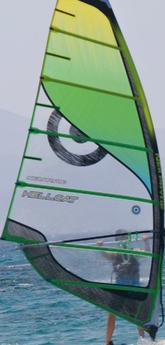

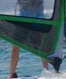

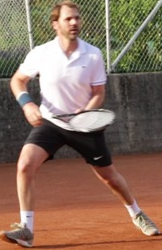

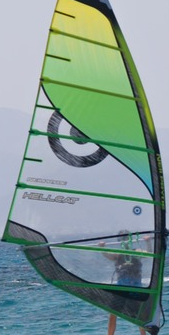

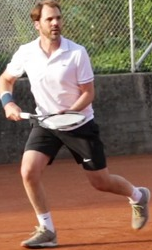

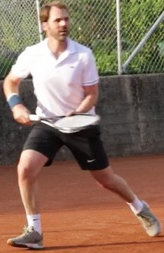

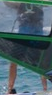

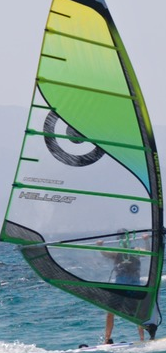

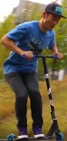

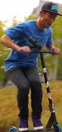

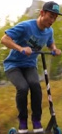

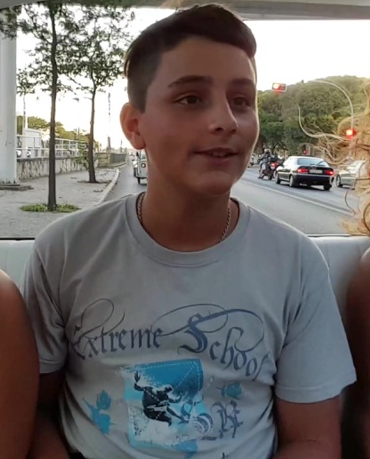

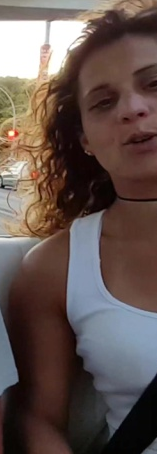

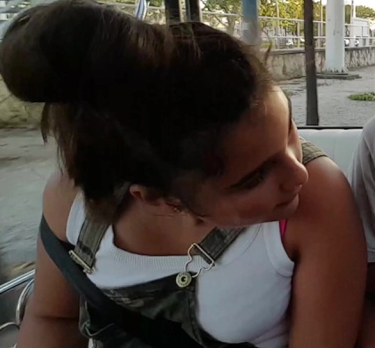

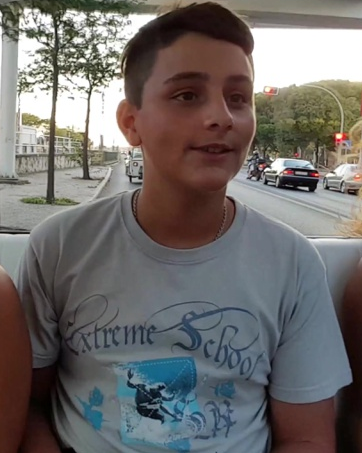

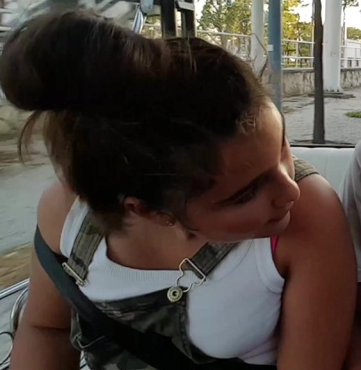

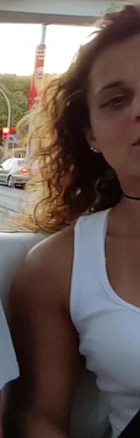

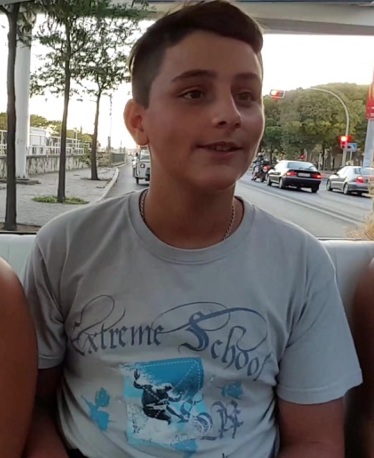

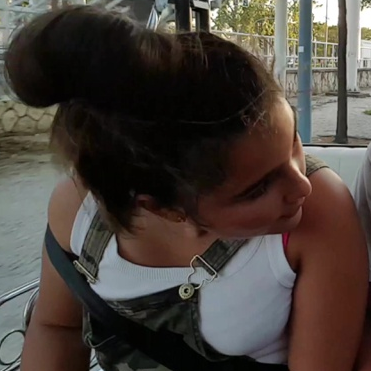

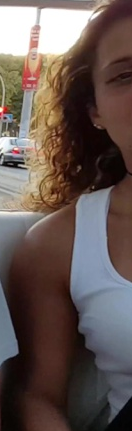

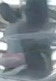

In [7]:
import cv2
from google.colab.patches import cv2_imshow

#loading json
folder_path = './drive/My Drive/'
with open(folder_path+'sdavis_json.txt') as json_file:
    davis_json = json.load(json_file)

#loading memmap
memmap_path = folder_path+'s_davis.mmap'
shape = davis_json["shape"]
newfp = np.memmap(memmap_path, dtype='uint8', mode='r', shape=tuple(shape))

contexts  = davis_json["contexts"]
objects =  davis_json["objects"]

for idx in contexts:

  object_list = contexts.get(str(idx))

  for object_ in object_list:
    object_mem = newfp[int(object_)]
    json_object = objects.get(str(object_))
    x = json_object['x']
    y = json_object['y']
    width = json_object['width']
    height = json_object['height']

    #show cropped images
    crop = newfp[int(object_), :, :width, :height]
    shape = crop.shape
    retranspose = crop.transpose(2,1,0).reshape(shape[2],shape[1],shape[0])  
    cv2_imshow(retranspose)